In [1]:
from __future__ import annotations

In [2]:
import warnings

warnings.filterwarnings("ignore") 

In [3]:
import sys
sys.path.append("../")

import os
from joblib import dump, load

from C_scrub.d_DASK_CUDA_RAPIDS_data_engineering import scrub_feature_engineering

from collections.abc import Iterator
from functools import partial
from datetime import datetime
import matplotlib.pyplot as plt

import xgboost
from cuml.metrics.accuracy import accuracy_score
import optuna

import dask_cudf
import dask
import dask.dataframe as dd
import distributed
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

# System set-up

In [4]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, 'A_data')
RESOURCES_DIR = os.path.join(BASE_DIR, 'B_resources', 'd_DASK_CUDA_RAPIDS')

In [5]:
dask.config.set({"array.backend": "cupy"})
dask.config.set({"dataframe.backend": "cudf"})

In [6]:
if __name__ == "__main__":
    def get_cluster():
        cluster = LocalCUDACluster(
            device_memory_limit='10GB',
            jit_unspill=True
        )
        client = Client(cluster)
        return client

    client = get_cluster()
    n_workers = len(client.scheduler_info()["workers"])

In [7]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:43543/status,
Dashboard: http://127.0.0.1:43543/status,Workers: 1
Total threads: 1,Total memory: 251.77 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42663,Workers: 1
Dashboard: http://127.0.0.1:43543/status,Total threads: 1
Started: Just now,Total memory: 251.77 GiB
Comm: tcp://127.0.0.1:36879,Total threads: 1
Dashboard: http://127.0.0.1:43593/status,Memory: 251.77 GiB
Nanny: tcp://127.0.0.1:33499,


In [8]:
import time
from contextlib import contextmanager

# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

# Collect data

In [9]:
data_compet = dd.read_csv(os.path.join(DATA_DIR, "train.csv")).set_index('id')
data_orig = dd.read_csv(os.path.join(DATA_DIR, 'horse.csv'))  # Include public data

data_orig['id'] = data_orig.index + data_compet.index.max() + 1
data_orig = data_orig.set_index('id')

data = dd.concat([data_compet, data_orig])
data = data.dropna(subset=['outcome'])
data = data.drop_duplicates()

del data_compet, data_orig

# Prepare data

In [10]:
data = scrub_feature_engineering(data, train=True)
data = dask_cudf.from_cudf(data, npartitions=2)

# Parameters definition

In [11]:
random_seed = 9421

# test split size
split_size = 0.2

#Number of cross-validation folds
n_folds = 4

# number of iteration for RamdomizedSearchCV
XGB_grid_n_iter_search = 100

# Number of parallel optuna jobs to run
N_JOBS = 1

# Number of converging serial trials to run in each job.
N_TRIALS = 10

# The number of training exercises that will be run in total is
# N_JOBS * N_TRIALS * n_folds

# Number of parallel training exercises
N_PARALLEL = 2

# Dask worker instance type and number
N_WORKERS = n_workers

# Split data

In [12]:
train_data, test_data = data.random_split([1- split_size, split_size], shuffle=True, random_state=random_seed)

In [13]:
print(train_data['outcome'].value_counts().compute())

0    618
2    387
1    226
Name: outcome, dtype: int64


In [14]:
print(test_data['outcome'].value_counts().compute())

0    134
2    100
1     69
Name: outcome, dtype: int64


In [15]:
train_data.persist()

if "train_data" in client.datasets:
    client.unpublish_dataset("train_data")
client.publish_dataset(train_data=train_data)

train_data.head()

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,numLesions,surgery_0.0,age_0.0,...,lesionCode_1.0,lesionCode_2.0,lesionCode_3.0,lesionCode_5.0,lesionCode_6.0,lesionCode_7.0,lesionCode_8.0,lesionCode_9.0,lesionCode_10.0,outcome
id,,,,,,,,,,,,,,,,,,,,,
591,0.920228,-0.369045,-0.472464,-0.785785,-0.573249,-0.575263,0.386810,0.264269,-0.661571,-0.262659,...,-0.368042,-0.206949,-0.18165,-0.535642,-0.185445,-0.159377,-0.355366,3.060207,-0.2,0
638,-0.257444,-0.545559,-0.568910,0.058562,-0.573249,-0.496918,-0.858120,0.264269,1.511554,-0.262659,...,-0.368042,-0.206949,-0.18165,-0.535642,-0.185445,-0.159377,-0.355366,3.060207,-0.2,1
703,-1.304263,-0.203076,-1.006999,1.465808,-0.096439,-0.377755,1.731854,0.264269,-0.661571,-0.262659,...,-0.368042,-0.206949,-0.18165,1.866917,-0.185445,-0.159377,-0.355366,-0.326775,-0.2,0
583,-2.220231,-0.046462,-0.207439,-1.348683,1.524715,-0.575263,0.257345,0.264269,-0.661571,-0.262659,...,-0.368042,-0.206949,-0.18165,-0.535642,-0.185445,-0.159377,-0.355366,-0.326775,-0.2,2
251,0.004261,0.504303,-0.568910,0.621461,-0.477887,-0.447669,1.302771,0.264269,-0.661571,-0.262659,...,-0.368042,-0.206949,-0.18165,-0.535642,-0.185445,6.274426,-0.355366,-0.326775,-0.2,0


# Train model

In [16]:
# Here we subset data for cross-validation
def make_cv_splits(ddf: dd.DataFrame, n_folds: int = 5) -> Iterator[tuple[dd.DataFrame, dd.DataFrame]]:
    frac = [1 / n_folds] * n_folds
    splits = ddf.random_split(frac, shuffle=True, random_state=random_seed)
    for i in range(n_folds):
        train = [splits[j] for j in range(n_folds) if j != i]
        test = splits[i]
        yield dd.concat(train), test

In [17]:
def train_once(
        train: dd.DataFrame,
        test: dd.DataFrame,
        sem: distributed.Semaphore,
        study_params: dict[str, float],
):
    distributed.secede()
    # Block until there are less than N_PARALLEL train_once critical sections running
    with sem:
        y_train = train["outcome"]
        X_train = train.drop(columns=["outcome"])
        y_test = test["outcome"]
        X_test = test.drop(columns=["outcome"])

        d_train = xgboost.dask.DaskQuantileDMatrix(None, X_train, y_train)
        
        # This has its own internal semaphore with a limit of 1
        model = xgboost.dask.train(
            None,
            {'objective':'multi:softmax',
             'num_class':3,
             "eval_metric": "mlogloss",
             "tree_method": "gpu_hist",
             'predictor':'gpu_predictor',
             **study_params},
            d_train,
            num_boost_round=XGB_grid_n_iter_search,
            evals=[(d_train, "train")],
        )
        predictions = xgboost.dask.predict(None, model, X_test)
        score = accuracy_score(y_test.astype("float32"), predictions, convert_dtype=True)
        return score

In [18]:
def train_model(
        ddf_name: str,
        n_folds: int,
        sem: distributed.Semaphore,
        study_params: dict[str, float],
):
    client = distributed.get_client()
    ddf = client.get_dataset(ddf_name)

    futures = [
        client.submit(train_once, train, test, sem, study_params, pure=False)
        for train, test in make_cv_splits(ddf, n_folds)
    ]

    try:
        distributed.secede()
    except KeyError:
        # Already seceded in a previous iteration of study.optimize()
        pass

    scores = client.gather(futures)
    return sum(scores) / len(scores)

In [19]:
def objective(trial, ddf_name: str, n_folds: int, sem: distributed.Semaphore) -> float:
    study_params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.2, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.3, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1),
        "max_depth": trial.suggest_int("max_depth", 1, 12),
        "max_leaves": trial.suggest_int("max_leaves", 0, 10)
    }
    return train_model(ddf_name, n_folds, sem, study_params)

In [20]:
total_studies = N_JOBS * N_TRIALS * n_folds
print(f"Total studies: {total_studies}")

# Create a single study and run some trials
start = datetime.now()
storage = optuna.integration.DaskStorage()
study = optuna.create_study(storage=storage, study_name="dask_cuml_optuna-HPO", direction="maximize")

# Run N_JOBS in parallel
# each job will run N_TRIALS converging trials in series
# each trial will start n_folds training exercises in parallel
# but only up to N_PARALLEL training exercise will actually submit
# tasks to the scheduler at the same time.

# In pure optuna, we would have used
# study.optimize(objective, n_trials=N_TRIALS, n_jobs=N_JOBS)
sem = distributed.Semaphore(N_PARALLEL)
futures = [
    client.submit(
        study.optimize,
        partial(objective, ddf_name="train_data", n_folds=n_folds, sem=sem),
        n_trials=N_TRIALS,
        pure=False,
    )
    for _ in range(N_JOBS)
]
client.gather(futures)

print(f"Total time:  {datetime.now() - start}")

[I 2023-11-01 13:14:02,626] A new study created in memory with name: dask_cuml_optuna-HPO


Total studies: 40


/home/jgsolar/anaconda3/envs/rapids-23.10/lib/python3.10/site-packages/distributed/protocol/pickle.py:96: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  return pickle.loads(x)
[13:14:09] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.94101
[1]	train-mlogloss:0.81963
[2]	train-mlogloss:0.75351
[3]	train-mlogloss:0.70740
[4]	train-mlogloss:0.66342
[5]	train-mlogloss:0.62739
[6]	train-mlogloss:0.59631
[7]	train-mlogloss:0.57140
[8]	train-mlogloss:0.55041
[9]	train-mlogloss:0.52964
[10]	train-mlogloss:0.51020
[11]	train-mlogloss:0.49055
[12]	train-mlogloss:0.47347
[13]	train-mlogloss:0.46043
[14]	train-mlogloss:0.44601
[15]	train-mlogloss:0.43427
[16]	train-mlogloss:0.42305
[17]	train-mlogloss:0.41186
[18]	train-mlogloss:0.40321
[19]	train-mlogloss:0.39570
[20]	train-mlogloss:0.38530
[21]	train-mlogloss:0.37562
[22]	train-mlogloss:0.36737
[23]	train-mlogloss:0.35941
[24]	train-mlogloss:0.35002
[25]	train-mlogloss:0.34398
[26]	train-mlogloss:0.33723
[27]	train-mlogloss:0.32930
[28]	train-mlogloss:0.32265
[29]	train-mlogloss:0.31641
[30]	train-mlogloss:0.30992
[31]	train-mlogloss:0.30356
[32]	train-mlogloss:0.29954
[33]	train-mlogloss:0.29248
[34]	train-mlogloss:0.28805
[35]	train-mlogloss:0.28250
[3

[13:14:11] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.92276
[1]	train-mlogloss:0.81312
[2]	train-mlogloss:0.74309
[3]	train-mlogloss:0.69096
[4]	train-mlogloss:0.64519
[5]	train-mlogloss:0.60809
[6]	train-mlogloss:0.58149
[7]	train-mlogloss:0.55763
[8]	train-mlogloss:0.53795
[9]	train-mlogloss:0.52422
[10]	train-mlogloss:0.50584
[11]	train-mlogloss:0.49089
[12]	train-mlogloss:0.47949
[13]	train-mlogloss:0.46551
[14]	train-mlogloss:0.45198
[15]	train-mlogloss:0.43893
[16]	train-mlogloss:0.42642
[17]	train-mlogloss:0.41642
[18]	train-mlogloss:0.40647
[19]	train-mlogloss:0.39566
[20]	train-mlogloss:0.38442
[21]	train-mlogloss:0.37619
[22]	train-mlogloss:0.36682
[23]	train-mlogloss:0.35562
[24]	train-mlogloss:0.34774
[25]	train-mlogloss:0.33937
[26]	train-mlogloss:0.33239
[27]	train-mlogloss:0.32542
[28]	train-mlogloss:0.31952
[29]	train-mlogloss:0.31354
[30]	train-mlogloss:0.30691
[31]	train-mlogloss:0.29974
[32]	train-mlogloss:0.29428
[33]	train-mlogloss:0.28834
[34]	train-mlogloss:0.28135
[35]	train-mlogloss:0.27592
[3

[13:14:19] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.92058
[1]	train-mlogloss:0.83197
[2]	train-mlogloss:0.75360
[3]	train-mlogloss:0.70847
[4]	train-mlogloss:0.66555
[5]	train-mlogloss:0.62951
[6]	train-mlogloss:0.59850
[7]	train-mlogloss:0.57283
[8]	train-mlogloss:0.55224
[9]	train-mlogloss:0.53018
[10]	train-mlogloss:0.50976
[11]	train-mlogloss:0.48714
[12]	train-mlogloss:0.47264
[13]	train-mlogloss:0.45830
[14]	train-mlogloss:0.44566
[15]	train-mlogloss:0.43445
[16]	train-mlogloss:0.42231
[17]	train-mlogloss:0.41029
[18]	train-mlogloss:0.39893
[19]	train-mlogloss:0.38926
[20]	train-mlogloss:0.38074
[21]	train-mlogloss:0.37112
[22]	train-mlogloss:0.36228
[23]	train-mlogloss:0.35422
[24]	train-mlogloss:0.34561
[25]	train-mlogloss:0.33664
[26]	train-mlogloss:0.32832
[27]	train-mlogloss:0.32117
[28]	train-mlogloss:0.31541
[29]	train-mlogloss:0.30935
[30]	train-mlogloss:0.30286
[31]	train-mlogloss:0.29659
[32]	train-mlogloss:0.28958
[33]	train-mlogloss:0.28489
[34]	train-mlogloss:0.28005
[35]	train-mlogloss:0.27399
[3

[13:14:22] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.92425
[1]	train-mlogloss:0.81192
[2]	train-mlogloss:0.75215
[3]	train-mlogloss:0.69707
[4]	train-mlogloss:0.65834
[5]	train-mlogloss:0.62432
[6]	train-mlogloss:0.60189
[7]	train-mlogloss:0.57782
[8]	train-mlogloss:0.55752
[9]	train-mlogloss:0.54033
[10]	train-mlogloss:0.52317
[11]	train-mlogloss:0.50716
[12]	train-mlogloss:0.49385
[13]	train-mlogloss:0.47964
[14]	train-mlogloss:0.46805
[15]	train-mlogloss:0.45487
[16]	train-mlogloss:0.44238
[17]	train-mlogloss:0.43052
[18]	train-mlogloss:0.41953
[19]	train-mlogloss:0.40814
[20]	train-mlogloss:0.39776
[21]	train-mlogloss:0.38803
[22]	train-mlogloss:0.37797
[23]	train-mlogloss:0.36981
[24]	train-mlogloss:0.36214
[25]	train-mlogloss:0.35424
[26]	train-mlogloss:0.34799
[27]	train-mlogloss:0.34138
[28]	train-mlogloss:0.33427
[29]	train-mlogloss:0.32675
[30]	train-mlogloss:0.32006
[31]	train-mlogloss:0.31324
[32]	train-mlogloss:0.30799
[33]	train-mlogloss:0.30381
[34]	train-mlogloss:0.29807
[35]	train-mlogloss:0.29299
[3

[I 2023-11-01 13:14:27,605] Trial 0 finished with value: 0.7369709461927414 and parameters: {'learning_rate': 0.3976299921442517, 'colsample_bytree': 0.37122520940653014, 'colsample_bynode': 0.5588567026177071, 'colsample_bylevel': 0.9332686498228233, 'reg_lambda': 0.9141597344535974, 'max_depth': 6, 'max_leaves': 10}. Best is trial 0 with value: 0.7369709461927414.
[13:14:33] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.97909
[1]	train-mlogloss:0.89759
[2]	train-mlogloss:0.84189
[3]	train-mlogloss:0.79709
[4]	train-mlogloss:0.75957
[5]	train-mlogloss:0.72889
[6]	train-mlogloss:0.70683
[7]	train-mlogloss:0.68865
[8]	train-mlogloss:0.67413
[9]	train-mlogloss:0.65915
[10]	train-mlogloss:0.64713
[11]	train-mlogloss:0.63416
[12]	train-mlogloss:0.62365
[13]	train-mlogloss:0.61270
[14]	train-mlogloss:0.60243
[15]	train-mlogloss:0.59336
[16]	train-mlogloss:0.58634
[17]	train-mlogloss:0.57815
[18]	train-mlogloss:0.57143
[19]	train-mlogloss:0.56439
[20]	train-mlogloss:0.55878
[21]	train-mlogloss:0.55379
[22]	train-mlogloss:0.54768
[23]	train-mlogloss:0.54126
[24]	train-mlogloss:0.53463
[25]	train-mlogloss:0.52999
[26]	train-mlogloss:0.52624
[27]	train-mlogloss:0.52125
[28]	train-mlogloss:0.51605
[29]	train-mlogloss:0.51257
[30]	train-mlogloss:0.50817
[31]	train-mlogloss:0.50397
[32]	train-mlogloss:0.50049
[33]	train-mlogloss:0.49652
[34]	train-mlogloss:0.49254
[35]	train-mlogloss:0.48898
[3

[13:14:34] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.96765
[1]	train-mlogloss:0.89026
[2]	train-mlogloss:0.83452
[3]	train-mlogloss:0.79013
[4]	train-mlogloss:0.75129
[5]	train-mlogloss:0.71794
[6]	train-mlogloss:0.69603
[7]	train-mlogloss:0.67774
[8]	train-mlogloss:0.66303
[9]	train-mlogloss:0.64711
[10]	train-mlogloss:0.63410
[11]	train-mlogloss:0.62008
[12]	train-mlogloss:0.60870
[13]	train-mlogloss:0.60066
[14]	train-mlogloss:0.59065
[15]	train-mlogloss:0.58183
[16]	train-mlogloss:0.57268
[17]	train-mlogloss:0.56424
[18]	train-mlogloss:0.55716
[19]	train-mlogloss:0.54939
[20]	train-mlogloss:0.54353
[21]	train-mlogloss:0.53759
[22]	train-mlogloss:0.53212
[23]	train-mlogloss:0.52625
[24]	train-mlogloss:0.52034
[25]	train-mlogloss:0.51624
[26]	train-mlogloss:0.51221
[27]	train-mlogloss:0.50833
[28]	train-mlogloss:0.50469
[29]	train-mlogloss:0.50152
[30]	train-mlogloss:0.49599
[31]	train-mlogloss:0.49230
[32]	train-mlogloss:0.48773
[33]	train-mlogloss:0.48444
[34]	train-mlogloss:0.48161
[35]	train-mlogloss:0.47907
[3

[13:14:43] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.98041
[1]	train-mlogloss:0.90360
[2]	train-mlogloss:0.85223
[3]	train-mlogloss:0.81288
[4]	train-mlogloss:0.77296
[5]	train-mlogloss:0.74238
[6]	train-mlogloss:0.72050
[7]	train-mlogloss:0.70134
[8]	train-mlogloss:0.68402
[9]	train-mlogloss:0.66724
[10]	train-mlogloss:0.65413
[11]	train-mlogloss:0.64044
[12]	train-mlogloss:0.62873
[13]	train-mlogloss:0.61856
[14]	train-mlogloss:0.60782
[15]	train-mlogloss:0.59777
[16]	train-mlogloss:0.58692
[17]	train-mlogloss:0.57784
[18]	train-mlogloss:0.57044
[19]	train-mlogloss:0.56279
[20]	train-mlogloss:0.55601
[21]	train-mlogloss:0.55133
[22]	train-mlogloss:0.54573
[23]	train-mlogloss:0.53952
[24]	train-mlogloss:0.53210
[25]	train-mlogloss:0.52702
[26]	train-mlogloss:0.52246
[27]	train-mlogloss:0.51708
[28]	train-mlogloss:0.51259
[29]	train-mlogloss:0.50761
[30]	train-mlogloss:0.50305
[31]	train-mlogloss:0.49736
[32]	train-mlogloss:0.49327
[33]	train-mlogloss:0.48960
[34]	train-mlogloss:0.48687
[35]	train-mlogloss:0.48317
[3

[13:14:45] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.97519
[1]	train-mlogloss:0.89632
[2]	train-mlogloss:0.84556
[3]	train-mlogloss:0.80166
[4]	train-mlogloss:0.76492
[5]	train-mlogloss:0.73505
[6]	train-mlogloss:0.71393
[7]	train-mlogloss:0.69827
[8]	train-mlogloss:0.68150
[9]	train-mlogloss:0.66589
[10]	train-mlogloss:0.65221
[11]	train-mlogloss:0.63920
[12]	train-mlogloss:0.62756
[13]	train-mlogloss:0.61699
[14]	train-mlogloss:0.60738
[15]	train-mlogloss:0.59891
[16]	train-mlogloss:0.58803
[17]	train-mlogloss:0.58053
[18]	train-mlogloss:0.57511
[19]	train-mlogloss:0.56657
[20]	train-mlogloss:0.56039
[21]	train-mlogloss:0.55475
[22]	train-mlogloss:0.54965
[23]	train-mlogloss:0.54379
[24]	train-mlogloss:0.53822
[25]	train-mlogloss:0.53329
[26]	train-mlogloss:0.52970
[27]	train-mlogloss:0.52495
[28]	train-mlogloss:0.51995
[29]	train-mlogloss:0.51526
[30]	train-mlogloss:0.51148
[31]	train-mlogloss:0.50768
[32]	train-mlogloss:0.50370
[33]	train-mlogloss:0.50022
[34]	train-mlogloss:0.49723
[35]	train-mlogloss:0.49358
[3

[I 2023-11-01 13:14:51,580] Trial 1 finished with value: 0.729174479842186 and parameters: {'learning_rate': 0.34220206356670835, 'colsample_bytree': 0.6396530944672056, 'colsample_bynode': 0.7064411838778561, 'colsample_bylevel': 0.7174408087207117, 'reg_lambda': 0.46997707966302393, 'max_depth': 2, 'max_leaves': 5}. Best is trial 0 with value: 0.7369709461927414.
[13:14:57] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.87512
[1]	train-mlogloss:0.79073
[2]	train-mlogloss:0.73453
[3]	train-mlogloss:0.69187
[4]	train-mlogloss:0.65362
[5]	train-mlogloss:0.62990
[6]	train-mlogloss:0.60912
[7]	train-mlogloss:0.59095
[8]	train-mlogloss:0.57332
[9]	train-mlogloss:0.55955
[10]	train-mlogloss:0.54578
[11]	train-mlogloss:0.53618
[12]	train-mlogloss:0.52637
[13]	train-mlogloss:0.51578
[14]	train-mlogloss:0.50669
[15]	train-mlogloss:0.49979
[16]	train-mlogloss:0.49179
[17]	train-mlogloss:0.48400
[18]	train-mlogloss:0.47565
[19]	train-mlogloss:0.46793
[20]	train-mlogloss:0.46191
[21]	train-mlogloss:0.45770
[22]	train-mlogloss:0.44848
[23]	train-mlogloss:0.44296
[24]	train-mlogloss:0.43778
[25]	train-mlogloss:0.43251
[26]	train-mlogloss:0.42820
[27]	train-mlogloss:0.42132
[28]	train-mlogloss:0.41674
[29]	train-mlogloss:0.41197
[30]	train-mlogloss:0.40905
[31]	train-mlogloss:0.40453
[32]	train-mlogloss:0.40023
[33]	train-mlogloss:0.39480
[34]	train-mlogloss:0.39159
[35]	train-mlogloss:0.38902
[3

[13:14:59] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.88935
[1]	train-mlogloss:0.79449
[2]	train-mlogloss:0.73815
[3]	train-mlogloss:0.69796
[4]	train-mlogloss:0.66202
[5]	train-mlogloss:0.63655
[6]	train-mlogloss:0.61746
[7]	train-mlogloss:0.59828
[8]	train-mlogloss:0.58541
[9]	train-mlogloss:0.57439
[10]	train-mlogloss:0.56117
[11]	train-mlogloss:0.54923
[12]	train-mlogloss:0.53729
[13]	train-mlogloss:0.52494
[14]	train-mlogloss:0.51494
[15]	train-mlogloss:0.50597
[16]	train-mlogloss:0.49902
[17]	train-mlogloss:0.48880
[18]	train-mlogloss:0.48251
[19]	train-mlogloss:0.47622
[20]	train-mlogloss:0.46940
[21]	train-mlogloss:0.46414
[22]	train-mlogloss:0.45861
[23]	train-mlogloss:0.45365
[24]	train-mlogloss:0.44731
[25]	train-mlogloss:0.44127
[26]	train-mlogloss:0.43609
[27]	train-mlogloss:0.42962
[28]	train-mlogloss:0.42520
[29]	train-mlogloss:0.42091
[30]	train-mlogloss:0.41660
[31]	train-mlogloss:0.41358
[32]	train-mlogloss:0.41070
[33]	train-mlogloss:0.40432
[34]	train-mlogloss:0.40139
[35]	train-mlogloss:0.39639
[3

[13:15:07] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.89355
[1]	train-mlogloss:0.79920
[2]	train-mlogloss:0.73835
[3]	train-mlogloss:0.69402
[4]	train-mlogloss:0.66169
[5]	train-mlogloss:0.63661
[6]	train-mlogloss:0.60875
[7]	train-mlogloss:0.59206
[8]	train-mlogloss:0.58071
[9]	train-mlogloss:0.56962
[10]	train-mlogloss:0.55446
[11]	train-mlogloss:0.54301
[12]	train-mlogloss:0.53251
[13]	train-mlogloss:0.52218
[14]	train-mlogloss:0.51357
[15]	train-mlogloss:0.50599
[16]	train-mlogloss:0.49790
[17]	train-mlogloss:0.48970
[18]	train-mlogloss:0.48050
[19]	train-mlogloss:0.47243
[20]	train-mlogloss:0.46642
[21]	train-mlogloss:0.46103
[22]	train-mlogloss:0.45528
[23]	train-mlogloss:0.44832
[24]	train-mlogloss:0.44470
[25]	train-mlogloss:0.44041
[26]	train-mlogloss:0.43501
[27]	train-mlogloss:0.43163
[28]	train-mlogloss:0.42764
[29]	train-mlogloss:0.42077
[30]	train-mlogloss:0.41623
[31]	train-mlogloss:0.41252
[32]	train-mlogloss:0.40951
[33]	train-mlogloss:0.40481
[34]	train-mlogloss:0.40063
[35]	train-mlogloss:0.39718
[3

[13:15:09] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.88664
[1]	train-mlogloss:0.79883
[2]	train-mlogloss:0.74050
[3]	train-mlogloss:0.69620
[4]	train-mlogloss:0.66551
[5]	train-mlogloss:0.63990
[6]	train-mlogloss:0.62041
[7]	train-mlogloss:0.60390
[8]	train-mlogloss:0.58323
[9]	train-mlogloss:0.57103
[10]	train-mlogloss:0.55956
[11]	train-mlogloss:0.55066
[12]	train-mlogloss:0.54030
[13]	train-mlogloss:0.53047
[14]	train-mlogloss:0.52300
[15]	train-mlogloss:0.51689
[16]	train-mlogloss:0.51123
[17]	train-mlogloss:0.50453
[18]	train-mlogloss:0.49767
[19]	train-mlogloss:0.48979
[20]	train-mlogloss:0.48147
[21]	train-mlogloss:0.47399
[22]	train-mlogloss:0.46699
[23]	train-mlogloss:0.46150
[24]	train-mlogloss:0.45672
[25]	train-mlogloss:0.45209
[26]	train-mlogloss:0.44807
[27]	train-mlogloss:0.44454
[28]	train-mlogloss:0.43924
[29]	train-mlogloss:0.43431
[30]	train-mlogloss:0.43081
[31]	train-mlogloss:0.42414
[32]	train-mlogloss:0.42113
[33]	train-mlogloss:0.41659
[34]	train-mlogloss:0.41267
[35]	train-mlogloss:0.41015
[3

[I 2023-11-01 13:15:14,790] Trial 2 finished with value: 0.7291232645511627 and parameters: {'learning_rate': 0.6182501173141502, 'colsample_bytree': 0.8901181609310589, 'colsample_bynode': 0.6807852358919637, 'colsample_bylevel': 0.8510939196570773, 'reg_lambda': 0.6763142905109187, 'max_depth': 2, 'max_leaves': 8}. Best is trial 0 with value: 0.7369709461927414.
[13:15:21] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.82082
[1]	train-mlogloss:0.69737
[2]	train-mlogloss:0.62427
[3]	train-mlogloss:0.57407
[4]	train-mlogloss:0.53046
[5]	train-mlogloss:0.49923
[6]	train-mlogloss:0.46833
[7]	train-mlogloss:0.44435
[8]	train-mlogloss:0.42166
[9]	train-mlogloss:0.40027
[10]	train-mlogloss:0.38132
[11]	train-mlogloss:0.36213
[12]	train-mlogloss:0.34343
[13]	train-mlogloss:0.32828
[14]	train-mlogloss:0.31317
[15]	train-mlogloss:0.29983
[16]	train-mlogloss:0.28839
[17]	train-mlogloss:0.27452
[18]	train-mlogloss:0.26150
[19]	train-mlogloss:0.25153
[20]	train-mlogloss:0.24273
[21]	train-mlogloss:0.23282
[22]	train-mlogloss:0.22255
[23]	train-mlogloss:0.21538
[24]	train-mlogloss:0.20783
[25]	train-mlogloss:0.19971
[26]	train-mlogloss:0.19206
[27]	train-mlogloss:0.18550
[28]	train-mlogloss:0.17583
[29]	train-mlogloss:0.16843
[30]	train-mlogloss:0.16106
[31]	train-mlogloss:0.15535
[32]	train-mlogloss:0.14856
[33]	train-mlogloss:0.14171
[34]	train-mlogloss:0.13753
[35]	train-mlogloss:0.13263
[3

[13:15:23] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.81617
[1]	train-mlogloss:0.69218
[2]	train-mlogloss:0.62188
[3]	train-mlogloss:0.56469
[4]	train-mlogloss:0.52561
[5]	train-mlogloss:0.49854
[6]	train-mlogloss:0.46873
[7]	train-mlogloss:0.44315
[8]	train-mlogloss:0.41911
[9]	train-mlogloss:0.39876
[10]	train-mlogloss:0.38017
[11]	train-mlogloss:0.36587
[12]	train-mlogloss:0.34937
[13]	train-mlogloss:0.33391
[14]	train-mlogloss:0.31989
[15]	train-mlogloss:0.30719
[16]	train-mlogloss:0.29565
[17]	train-mlogloss:0.28425
[18]	train-mlogloss:0.27387
[19]	train-mlogloss:0.26406
[20]	train-mlogloss:0.25379
[21]	train-mlogloss:0.24314
[22]	train-mlogloss:0.23243
[23]	train-mlogloss:0.22444
[24]	train-mlogloss:0.21606
[25]	train-mlogloss:0.20901
[26]	train-mlogloss:0.20288
[27]	train-mlogloss:0.19429
[28]	train-mlogloss:0.18474
[29]	train-mlogloss:0.17760
[30]	train-mlogloss:0.17025
[31]	train-mlogloss:0.16274
[32]	train-mlogloss:0.15660
[33]	train-mlogloss:0.15090
[34]	train-mlogloss:0.14591
[35]	train-mlogloss:0.14047
[3

[13:15:31] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.79293
[1]	train-mlogloss:0.68233
[2]	train-mlogloss:0.60831
[3]	train-mlogloss:0.55897
[4]	train-mlogloss:0.51721
[5]	train-mlogloss:0.48416
[6]	train-mlogloss:0.45406
[7]	train-mlogloss:0.43370
[8]	train-mlogloss:0.41347
[9]	train-mlogloss:0.39605
[10]	train-mlogloss:0.37849
[11]	train-mlogloss:0.36349
[12]	train-mlogloss:0.34657
[13]	train-mlogloss:0.33284
[14]	train-mlogloss:0.31767
[15]	train-mlogloss:0.30617
[16]	train-mlogloss:0.29476
[17]	train-mlogloss:0.28260
[18]	train-mlogloss:0.27144
[19]	train-mlogloss:0.26219
[20]	train-mlogloss:0.25357
[21]	train-mlogloss:0.24564
[22]	train-mlogloss:0.23674
[23]	train-mlogloss:0.22619
[24]	train-mlogloss:0.21770
[25]	train-mlogloss:0.20979
[26]	train-mlogloss:0.20141
[27]	train-mlogloss:0.19334
[28]	train-mlogloss:0.18725
[29]	train-mlogloss:0.17974
[30]	train-mlogloss:0.17485
[31]	train-mlogloss:0.16709
[32]	train-mlogloss:0.16173
[33]	train-mlogloss:0.15680
[34]	train-mlogloss:0.15008
[35]	train-mlogloss:0.14522
[3

[13:15:33] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.82160
[1]	train-mlogloss:0.70284
[2]	train-mlogloss:0.62545
[3]	train-mlogloss:0.56243
[4]	train-mlogloss:0.51688
[5]	train-mlogloss:0.47605
[6]	train-mlogloss:0.44833
[7]	train-mlogloss:0.42532
[8]	train-mlogloss:0.40274
[9]	train-mlogloss:0.38325
[10]	train-mlogloss:0.36454
[11]	train-mlogloss:0.35166
[12]	train-mlogloss:0.33224
[13]	train-mlogloss:0.31786
[14]	train-mlogloss:0.30451
[15]	train-mlogloss:0.29372
[16]	train-mlogloss:0.28029
[17]	train-mlogloss:0.26751
[18]	train-mlogloss:0.25522
[19]	train-mlogloss:0.24527
[20]	train-mlogloss:0.23528
[21]	train-mlogloss:0.22591
[22]	train-mlogloss:0.21797
[23]	train-mlogloss:0.20833
[24]	train-mlogloss:0.20117
[25]	train-mlogloss:0.19306
[26]	train-mlogloss:0.18587
[27]	train-mlogloss:0.17649
[28]	train-mlogloss:0.16868
[29]	train-mlogloss:0.16073
[30]	train-mlogloss:0.15435
[31]	train-mlogloss:0.14893
[32]	train-mlogloss:0.14298
[33]	train-mlogloss:0.13758
[34]	train-mlogloss:0.13132
[35]	train-mlogloss:0.12562
[3

[I 2023-11-01 13:15:39,782] Trial 3 finished with value: 0.7365312874317169 and parameters: {'learning_rate': 0.7523057318636015, 'colsample_bytree': 0.6315097206947129, 'colsample_bynode': 0.7476068807203186, 'colsample_bylevel': 0.5308477331620628, 'reg_lambda': 0.615892514222672, 'max_depth': 9, 'max_leaves': 10}. Best is trial 0 with value: 0.7369709461927414.
[13:15:45] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.75949
[1]	train-mlogloss:0.65126
[2]	train-mlogloss:0.57321
[3]	train-mlogloss:0.52770
[4]	train-mlogloss:0.49006
[5]	train-mlogloss:0.45837
[6]	train-mlogloss:0.43016
[7]	train-mlogloss:0.40459
[8]	train-mlogloss:0.38540
[9]	train-mlogloss:0.36368
[10]	train-mlogloss:0.34145
[11]	train-mlogloss:0.32384
[12]	train-mlogloss:0.30739
[13]	train-mlogloss:0.29509
[14]	train-mlogloss:0.27946
[15]	train-mlogloss:0.26812
[16]	train-mlogloss:0.25559
[17]	train-mlogloss:0.24433
[18]	train-mlogloss:0.23539
[19]	train-mlogloss:0.22229
[20]	train-mlogloss:0.21313
[21]	train-mlogloss:0.20457
[22]	train-mlogloss:0.19746
[23]	train-mlogloss:0.18837
[24]	train-mlogloss:0.18073
[25]	train-mlogloss:0.17269
[26]	train-mlogloss:0.16496
[27]	train-mlogloss:0.15841
[28]	train-mlogloss:0.15084
[29]	train-mlogloss:0.14313
[30]	train-mlogloss:0.13735
[31]	train-mlogloss:0.13321
[32]	train-mlogloss:0.12904
[33]	train-mlogloss:0.12408
[34]	train-mlogloss:0.11994
[35]	train-mlogloss:0.11473
[3

[13:15:48] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.76809
[1]	train-mlogloss:0.65868
[2]	train-mlogloss:0.58432
[3]	train-mlogloss:0.53689
[4]	train-mlogloss:0.49997
[5]	train-mlogloss:0.46764
[6]	train-mlogloss:0.44089
[7]	train-mlogloss:0.42025
[8]	train-mlogloss:0.40175
[9]	train-mlogloss:0.37881
[10]	train-mlogloss:0.35774
[11]	train-mlogloss:0.34269
[12]	train-mlogloss:0.32790
[13]	train-mlogloss:0.30762
[14]	train-mlogloss:0.29191
[15]	train-mlogloss:0.27569
[16]	train-mlogloss:0.26587
[17]	train-mlogloss:0.25325
[18]	train-mlogloss:0.24021
[19]	train-mlogloss:0.23029
[20]	train-mlogloss:0.22171
[21]	train-mlogloss:0.21089
[22]	train-mlogloss:0.20303
[23]	train-mlogloss:0.19391
[24]	train-mlogloss:0.18371
[25]	train-mlogloss:0.17557
[26]	train-mlogloss:0.16856
[27]	train-mlogloss:0.16098
[28]	train-mlogloss:0.15403
[29]	train-mlogloss:0.14768
[30]	train-mlogloss:0.14314
[31]	train-mlogloss:0.13702
[32]	train-mlogloss:0.13198
[33]	train-mlogloss:0.12650
[34]	train-mlogloss:0.12169
[35]	train-mlogloss:0.11513
[3

[13:15:57] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.77498
[1]	train-mlogloss:0.65721
[2]	train-mlogloss:0.58040
[3]	train-mlogloss:0.53630
[4]	train-mlogloss:0.50213
[5]	train-mlogloss:0.46546
[6]	train-mlogloss:0.43025
[7]	train-mlogloss:0.40827
[8]	train-mlogloss:0.38111
[9]	train-mlogloss:0.35986
[10]	train-mlogloss:0.33835
[11]	train-mlogloss:0.31954
[12]	train-mlogloss:0.30033
[13]	train-mlogloss:0.28635
[14]	train-mlogloss:0.27461
[15]	train-mlogloss:0.26466
[16]	train-mlogloss:0.25485
[17]	train-mlogloss:0.24489
[18]	train-mlogloss:0.23468
[19]	train-mlogloss:0.22689
[20]	train-mlogloss:0.21780
[21]	train-mlogloss:0.20620
[22]	train-mlogloss:0.19659
[23]	train-mlogloss:0.18610
[24]	train-mlogloss:0.17656
[25]	train-mlogloss:0.16813
[26]	train-mlogloss:0.16148
[27]	train-mlogloss:0.15407
[28]	train-mlogloss:0.14727
[29]	train-mlogloss:0.14194
[30]	train-mlogloss:0.13652
[31]	train-mlogloss:0.12879
[32]	train-mlogloss:0.12383
[33]	train-mlogloss:0.11892
[34]	train-mlogloss:0.11380
[35]	train-mlogloss:0.10990
[3

[13:15:59] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.77980
[1]	train-mlogloss:0.66014
[2]	train-mlogloss:0.58994
[3]	train-mlogloss:0.54855
[4]	train-mlogloss:0.51172
[5]	train-mlogloss:0.47944
[6]	train-mlogloss:0.44495
[7]	train-mlogloss:0.41904
[8]	train-mlogloss:0.39600
[9]	train-mlogloss:0.37784
[10]	train-mlogloss:0.36117
[11]	train-mlogloss:0.34345
[12]	train-mlogloss:0.32755
[13]	train-mlogloss:0.31249
[14]	train-mlogloss:0.30029
[15]	train-mlogloss:0.28208
[16]	train-mlogloss:0.26945
[17]	train-mlogloss:0.25841
[18]	train-mlogloss:0.24874
[19]	train-mlogloss:0.23754
[20]	train-mlogloss:0.22936
[21]	train-mlogloss:0.22066
[22]	train-mlogloss:0.20952
[23]	train-mlogloss:0.20080
[24]	train-mlogloss:0.19300
[25]	train-mlogloss:0.18231
[26]	train-mlogloss:0.17148
[27]	train-mlogloss:0.16581
[28]	train-mlogloss:0.15975
[29]	train-mlogloss:0.15294
[30]	train-mlogloss:0.14701
[31]	train-mlogloss:0.14197
[32]	train-mlogloss:0.13670
[33]	train-mlogloss:0.13206
[34]	train-mlogloss:0.12491
[35]	train-mlogloss:0.12042
[3

[I 2023-11-01 13:16:05,382] Trial 4 finished with value: 0.7438382506370544 and parameters: {'learning_rate': 0.8472490833953377, 'colsample_bytree': 0.7484041755408862, 'colsample_bynode': 0.9034219054024353, 'colsample_bylevel': 0.9115953859850356, 'reg_lambda': 0.11449584908240895, 'max_depth': 7, 'max_leaves': 8}. Best is trial 4 with value: 0.7438382506370544.
[13:16:11] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.86061
[1]	train-mlogloss:0.75204
[2]	train-mlogloss:0.67443
[3]	train-mlogloss:0.62393
[4]	train-mlogloss:0.58385
[5]	train-mlogloss:0.55208
[6]	train-mlogloss:0.52306
[7]	train-mlogloss:0.49817
[8]	train-mlogloss:0.47751
[9]	train-mlogloss:0.45710
[10]	train-mlogloss:0.43735
[11]	train-mlogloss:0.42005
[12]	train-mlogloss:0.40529
[13]	train-mlogloss:0.39009
[14]	train-mlogloss:0.37570
[15]	train-mlogloss:0.36391
[16]	train-mlogloss:0.35126
[17]	train-mlogloss:0.33995
[18]	train-mlogloss:0.33100
[19]	train-mlogloss:0.31900
[20]	train-mlogloss:0.30663
[21]	train-mlogloss:0.29584
[22]	train-mlogloss:0.28700
[23]	train-mlogloss:0.27909
[24]	train-mlogloss:0.27231
[25]	train-mlogloss:0.26462
[26]	train-mlogloss:0.25703
[27]	train-mlogloss:0.25124
[28]	train-mlogloss:0.24476
[29]	train-mlogloss:0.23902
[30]	train-mlogloss:0.23139
[31]	train-mlogloss:0.22489
[32]	train-mlogloss:0.21989
[33]	train-mlogloss:0.21426
[34]	train-mlogloss:0.20849
[35]	train-mlogloss:0.20441
[3

[13:16:13] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.88705
[1]	train-mlogloss:0.74851
[2]	train-mlogloss:0.68071
[3]	train-mlogloss:0.62557
[4]	train-mlogloss:0.59477
[5]	train-mlogloss:0.56036
[6]	train-mlogloss:0.52978
[7]	train-mlogloss:0.50181
[8]	train-mlogloss:0.47916
[9]	train-mlogloss:0.45826
[10]	train-mlogloss:0.43892
[11]	train-mlogloss:0.42167
[12]	train-mlogloss:0.40762
[13]	train-mlogloss:0.39291
[14]	train-mlogloss:0.38196
[15]	train-mlogloss:0.37064
[16]	train-mlogloss:0.36097
[17]	train-mlogloss:0.35027
[18]	train-mlogloss:0.34062
[19]	train-mlogloss:0.33069
[20]	train-mlogloss:0.32035
[21]	train-mlogloss:0.31122
[22]	train-mlogloss:0.30272
[23]	train-mlogloss:0.29406
[24]	train-mlogloss:0.28752
[25]	train-mlogloss:0.27990
[26]	train-mlogloss:0.27182
[27]	train-mlogloss:0.26452
[28]	train-mlogloss:0.25495
[29]	train-mlogloss:0.24844
[30]	train-mlogloss:0.24342
[31]	train-mlogloss:0.23608
[32]	train-mlogloss:0.22993
[33]	train-mlogloss:0.22438
[34]	train-mlogloss:0.21849
[35]	train-mlogloss:0.21152
[3

[13:16:22] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.88330
[1]	train-mlogloss:0.75052
[2]	train-mlogloss:0.69179
[3]	train-mlogloss:0.64732
[4]	train-mlogloss:0.61240
[5]	train-mlogloss:0.57542
[6]	train-mlogloss:0.54266
[7]	train-mlogloss:0.51968
[8]	train-mlogloss:0.49795
[9]	train-mlogloss:0.47959
[10]	train-mlogloss:0.45979
[11]	train-mlogloss:0.44219
[12]	train-mlogloss:0.42734
[13]	train-mlogloss:0.41334
[14]	train-mlogloss:0.39926
[15]	train-mlogloss:0.38647
[16]	train-mlogloss:0.37698
[17]	train-mlogloss:0.36431
[18]	train-mlogloss:0.35458
[19]	train-mlogloss:0.34011
[20]	train-mlogloss:0.33023
[21]	train-mlogloss:0.32055
[22]	train-mlogloss:0.31034
[23]	train-mlogloss:0.30286
[24]	train-mlogloss:0.29490
[25]	train-mlogloss:0.28643
[26]	train-mlogloss:0.27875
[27]	train-mlogloss:0.27086
[28]	train-mlogloss:0.26150
[29]	train-mlogloss:0.25567
[30]	train-mlogloss:0.24903
[31]	train-mlogloss:0.24129
[32]	train-mlogloss:0.23620
[33]	train-mlogloss:0.22980
[34]	train-mlogloss:0.22263
[35]	train-mlogloss:0.21771
[3

[13:16:24] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.89438
[1]	train-mlogloss:0.75807
[2]	train-mlogloss:0.69548
[3]	train-mlogloss:0.65186
[4]	train-mlogloss:0.60562
[5]	train-mlogloss:0.57479
[6]	train-mlogloss:0.54096
[7]	train-mlogloss:0.51565
[8]	train-mlogloss:0.48669
[9]	train-mlogloss:0.46664
[10]	train-mlogloss:0.44544
[11]	train-mlogloss:0.42545
[12]	train-mlogloss:0.40775
[13]	train-mlogloss:0.39165
[14]	train-mlogloss:0.37806
[15]	train-mlogloss:0.36830
[16]	train-mlogloss:0.35572
[17]	train-mlogloss:0.34275
[18]	train-mlogloss:0.33119
[19]	train-mlogloss:0.32082
[20]	train-mlogloss:0.31059
[21]	train-mlogloss:0.30136
[22]	train-mlogloss:0.29249
[23]	train-mlogloss:0.28381
[24]	train-mlogloss:0.27616
[25]	train-mlogloss:0.26822
[26]	train-mlogloss:0.25978
[27]	train-mlogloss:0.25369
[28]	train-mlogloss:0.24709
[29]	train-mlogloss:0.24059
[30]	train-mlogloss:0.23217
[31]	train-mlogloss:0.22528
[32]	train-mlogloss:0.21889
[33]	train-mlogloss:0.21159
[34]	train-mlogloss:0.20671
[35]	train-mlogloss:0.20240
[3

[I 2023-11-01 13:16:30,932] Trial 5 finished with value: 0.7355185151100159 and parameters: {'learning_rate': 0.551201277424491, 'colsample_bytree': 0.42851286135358346, 'colsample_bynode': 0.930971507648019, 'colsample_bylevel': 0.6487958601737338, 'reg_lambda': 0.32325003435267974, 'max_depth': 10, 'max_leaves': 9}. Best is trial 4 with value: 0.7438382506370544.
[13:16:36] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.98520
[1]	train-mlogloss:0.92596
[2]	train-mlogloss:0.88381
[3]	train-mlogloss:0.85675
[4]	train-mlogloss:0.80525
[5]	train-mlogloss:0.78525
[6]	train-mlogloss:0.76264
[7]	train-mlogloss:0.72768
[8]	train-mlogloss:0.70925
[9]	train-mlogloss:0.69187
[10]	train-mlogloss:0.67930
[11]	train-mlogloss:0.66947
[12]	train-mlogloss:0.66048
[13]	train-mlogloss:0.65155
[14]	train-mlogloss:0.64421
[15]	train-mlogloss:0.63442
[16]	train-mlogloss:0.62584
[17]	train-mlogloss:0.62063
[18]	train-mlogloss:0.61632
[19]	train-mlogloss:0.60683
[20]	train-mlogloss:0.60234
[21]	train-mlogloss:0.59480
[22]	train-mlogloss:0.58838
[23]	train-mlogloss:0.58053
[24]	train-mlogloss:0.57457
[25]	train-mlogloss:0.57120
[26]	train-mlogloss:0.56748
[27]	train-mlogloss:0.56131
[28]	train-mlogloss:0.55570
[29]	train-mlogloss:0.55128
[30]	train-mlogloss:0.54653
[31]	train-mlogloss:0.54334
[32]	train-mlogloss:0.54011
[33]	train-mlogloss:0.53729
[34]	train-mlogloss:0.53379
[35]	train-mlogloss:0.53020
[3

[13:16:38] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.99734
[1]	train-mlogloss:0.94188
[2]	train-mlogloss:0.89991
[3]	train-mlogloss:0.86795
[4]	train-mlogloss:0.82149
[5]	train-mlogloss:0.79852
[6]	train-mlogloss:0.77931
[7]	train-mlogloss:0.73896
[8]	train-mlogloss:0.71629
[9]	train-mlogloss:0.69955
[10]	train-mlogloss:0.68821
[11]	train-mlogloss:0.67647
[12]	train-mlogloss:0.66637
[13]	train-mlogloss:0.65745
[14]	train-mlogloss:0.65022
[15]	train-mlogloss:0.63916
[16]	train-mlogloss:0.62869
[17]	train-mlogloss:0.62271
[18]	train-mlogloss:0.61841
[19]	train-mlogloss:0.60907
[20]	train-mlogloss:0.60282
[21]	train-mlogloss:0.59519
[22]	train-mlogloss:0.58921
[23]	train-mlogloss:0.58411
[24]	train-mlogloss:0.57627
[25]	train-mlogloss:0.57212
[26]	train-mlogloss:0.56784
[27]	train-mlogloss:0.56270
[28]	train-mlogloss:0.55871
[29]	train-mlogloss:0.55561
[30]	train-mlogloss:0.55117
[31]	train-mlogloss:0.54696
[32]	train-mlogloss:0.54365
[33]	train-mlogloss:0.54042
[34]	train-mlogloss:0.53645
[35]	train-mlogloss:0.53365
[3

[13:16:46] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.99750
[1]	train-mlogloss:0.93843
[2]	train-mlogloss:0.90229
[3]	train-mlogloss:0.87206
[4]	train-mlogloss:0.82242
[5]	train-mlogloss:0.79866
[6]	train-mlogloss:0.77465
[7]	train-mlogloss:0.73078
[8]	train-mlogloss:0.71146
[9]	train-mlogloss:0.69296
[10]	train-mlogloss:0.68439
[11]	train-mlogloss:0.67483
[12]	train-mlogloss:0.66552
[13]	train-mlogloss:0.65839
[14]	train-mlogloss:0.65041
[15]	train-mlogloss:0.63972
[16]	train-mlogloss:0.63143
[17]	train-mlogloss:0.62593
[18]	train-mlogloss:0.62030
[19]	train-mlogloss:0.61233
[20]	train-mlogloss:0.60600
[21]	train-mlogloss:0.59883
[22]	train-mlogloss:0.59499
[23]	train-mlogloss:0.58857
[24]	train-mlogloss:0.58167
[25]	train-mlogloss:0.57850
[26]	train-mlogloss:0.57397
[27]	train-mlogloss:0.56870
[28]	train-mlogloss:0.56125
[29]	train-mlogloss:0.55719
[30]	train-mlogloss:0.55289
[31]	train-mlogloss:0.54938
[32]	train-mlogloss:0.54603
[33]	train-mlogloss:0.54242
[34]	train-mlogloss:0.53807
[35]	train-mlogloss:0.53489
[3

[13:16:47] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:1.00159
[1]	train-mlogloss:0.94585
[2]	train-mlogloss:0.91190
[3]	train-mlogloss:0.87768
[4]	train-mlogloss:0.82965
[5]	train-mlogloss:0.80314
[6]	train-mlogloss:0.78215
[7]	train-mlogloss:0.74123
[8]	train-mlogloss:0.71942
[9]	train-mlogloss:0.70101
[10]	train-mlogloss:0.69101
[11]	train-mlogloss:0.68088
[12]	train-mlogloss:0.67386
[13]	train-mlogloss:0.66602
[14]	train-mlogloss:0.66003
[15]	train-mlogloss:0.64918
[16]	train-mlogloss:0.64174
[17]	train-mlogloss:0.63571
[18]	train-mlogloss:0.63076
[19]	train-mlogloss:0.62058
[20]	train-mlogloss:0.61371
[21]	train-mlogloss:0.60715
[22]	train-mlogloss:0.60078
[23]	train-mlogloss:0.59471
[24]	train-mlogloss:0.58751
[25]	train-mlogloss:0.58283
[26]	train-mlogloss:0.57808
[27]	train-mlogloss:0.57245
[28]	train-mlogloss:0.56587
[29]	train-mlogloss:0.56167
[30]	train-mlogloss:0.55753
[31]	train-mlogloss:0.55335
[32]	train-mlogloss:0.54948
[33]	train-mlogloss:0.54584
[34]	train-mlogloss:0.54216
[35]	train-mlogloss:0.53965
[3

[I 2023-11-01 13:16:53,212] Trial 6 finished with value: 0.7243933081626892 and parameters: {'learning_rate': 0.7437438950803794, 'colsample_bytree': 0.49043629206629724, 'colsample_bynode': 0.30575353702971353, 'colsample_bylevel': 0.9310065560723173, 'reg_lambda': 0.06249401640302632, 'max_depth': 1, 'max_leaves': 4}. Best is trial 4 with value: 0.7438382506370544.
[13:16:58] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.88340
[1]	train-mlogloss:0.77262
[2]	train-mlogloss:0.68362
[3]	train-mlogloss:0.63409
[4]	train-mlogloss:0.59430
[5]	train-mlogloss:0.56276
[6]	train-mlogloss:0.53758
[7]	train-mlogloss:0.51184
[8]	train-mlogloss:0.49097
[9]	train-mlogloss:0.47666
[10]	train-mlogloss:0.45851
[11]	train-mlogloss:0.43883
[12]	train-mlogloss:0.42414
[13]	train-mlogloss:0.41020
[14]	train-mlogloss:0.39525
[15]	train-mlogloss:0.38559
[16]	train-mlogloss:0.37194
[17]	train-mlogloss:0.36196
[18]	train-mlogloss:0.35293
[19]	train-mlogloss:0.34226
[20]	train-mlogloss:0.33296
[21]	train-mlogloss:0.32309
[22]	train-mlogloss:0.31639
[23]	train-mlogloss:0.30886
[24]	train-mlogloss:0.30278
[25]	train-mlogloss:0.29523
[26]	train-mlogloss:0.28808
[27]	train-mlogloss:0.27999
[28]	train-mlogloss:0.27240
[29]	train-mlogloss:0.26629
[30]	train-mlogloss:0.26129
[31]	train-mlogloss:0.25440
[32]	train-mlogloss:0.24571
[33]	train-mlogloss:0.24035
[34]	train-mlogloss:0.23612
[35]	train-mlogloss:0.22960
[3

[13:17:01] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.87612
[1]	train-mlogloss:0.75782
[2]	train-mlogloss:0.68150
[3]	train-mlogloss:0.62650
[4]	train-mlogloss:0.59364
[5]	train-mlogloss:0.56680
[6]	train-mlogloss:0.54091
[7]	train-mlogloss:0.52319
[8]	train-mlogloss:0.50165
[9]	train-mlogloss:0.47958
[10]	train-mlogloss:0.46149
[11]	train-mlogloss:0.44620
[12]	train-mlogloss:0.42954
[13]	train-mlogloss:0.41541
[14]	train-mlogloss:0.40161
[15]	train-mlogloss:0.38904
[16]	train-mlogloss:0.37953
[17]	train-mlogloss:0.36879
[18]	train-mlogloss:0.35606
[19]	train-mlogloss:0.34520
[20]	train-mlogloss:0.33688
[21]	train-mlogloss:0.32799
[22]	train-mlogloss:0.31729
[23]	train-mlogloss:0.30807
[24]	train-mlogloss:0.30134
[25]	train-mlogloss:0.29350
[26]	train-mlogloss:0.28699
[27]	train-mlogloss:0.27861
[28]	train-mlogloss:0.27211
[29]	train-mlogloss:0.26497
[30]	train-mlogloss:0.25745
[31]	train-mlogloss:0.25107
[32]	train-mlogloss:0.24593
[33]	train-mlogloss:0.23931
[34]	train-mlogloss:0.23473
[35]	train-mlogloss:0.22973
[3

[13:17:09] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.88994
[1]	train-mlogloss:0.77305
[2]	train-mlogloss:0.69978
[3]	train-mlogloss:0.64805
[4]	train-mlogloss:0.61331
[5]	train-mlogloss:0.58015
[6]	train-mlogloss:0.55083
[7]	train-mlogloss:0.52776
[8]	train-mlogloss:0.50045
[9]	train-mlogloss:0.47990
[10]	train-mlogloss:0.46338
[11]	train-mlogloss:0.44711
[12]	train-mlogloss:0.42731
[13]	train-mlogloss:0.41449
[14]	train-mlogloss:0.40327
[15]	train-mlogloss:0.38937
[16]	train-mlogloss:0.37717
[17]	train-mlogloss:0.36472
[18]	train-mlogloss:0.35163
[19]	train-mlogloss:0.34349
[20]	train-mlogloss:0.33442
[21]	train-mlogloss:0.32478
[22]	train-mlogloss:0.31633
[23]	train-mlogloss:0.30651
[24]	train-mlogloss:0.29835
[25]	train-mlogloss:0.29001
[26]	train-mlogloss:0.28252
[27]	train-mlogloss:0.27722
[28]	train-mlogloss:0.27178
[29]	train-mlogloss:0.26559
[30]	train-mlogloss:0.25864
[31]	train-mlogloss:0.25163
[32]	train-mlogloss:0.24632
[33]	train-mlogloss:0.23991
[34]	train-mlogloss:0.23371
[35]	train-mlogloss:0.22931
[3

[13:17:12] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.87924
[1]	train-mlogloss:0.77696
[2]	train-mlogloss:0.69367
[3]	train-mlogloss:0.64118
[4]	train-mlogloss:0.60469
[5]	train-mlogloss:0.57308
[6]	train-mlogloss:0.54332
[7]	train-mlogloss:0.51744
[8]	train-mlogloss:0.49603
[9]	train-mlogloss:0.47463
[10]	train-mlogloss:0.46056
[11]	train-mlogloss:0.44182
[12]	train-mlogloss:0.42918
[13]	train-mlogloss:0.41071
[14]	train-mlogloss:0.39920
[15]	train-mlogloss:0.38926
[16]	train-mlogloss:0.37542
[17]	train-mlogloss:0.36460
[18]	train-mlogloss:0.35151
[19]	train-mlogloss:0.34343
[20]	train-mlogloss:0.33126
[21]	train-mlogloss:0.32242
[22]	train-mlogloss:0.31268
[23]	train-mlogloss:0.30260
[24]	train-mlogloss:0.29530
[25]	train-mlogloss:0.28715
[26]	train-mlogloss:0.28000
[27]	train-mlogloss:0.27210
[28]	train-mlogloss:0.26570
[29]	train-mlogloss:0.26022
[30]	train-mlogloss:0.25403
[31]	train-mlogloss:0.24814
[32]	train-mlogloss:0.24218
[33]	train-mlogloss:0.23583
[34]	train-mlogloss:0.23097
[35]	train-mlogloss:0.22559
[3

[I 2023-11-01 13:17:18,227] Trial 7 finished with value: 0.7259114980697632 and parameters: {'learning_rate': 0.6257647782117052, 'colsample_bytree': 0.41376862936740244, 'colsample_bynode': 0.37080564089878476, 'colsample_bylevel': 0.8903435283969761, 'reg_lambda': 0.7483535657876188, 'max_depth': 12, 'max_leaves': 9}. Best is trial 4 with value: 0.7438382506370544.
[13:17:24] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.75192
[1]	train-mlogloss:0.64158
[2]	train-mlogloss:0.57008
[3]	train-mlogloss:0.53122
[4]	train-mlogloss:0.49143
[5]	train-mlogloss:0.45937
[6]	train-mlogloss:0.43227
[7]	train-mlogloss:0.40948
[8]	train-mlogloss:0.38327
[9]	train-mlogloss:0.36280
[10]	train-mlogloss:0.34269
[11]	train-mlogloss:0.32932
[12]	train-mlogloss:0.31190
[13]	train-mlogloss:0.29797
[14]	train-mlogloss:0.28364
[15]	train-mlogloss:0.27023
[16]	train-mlogloss:0.25556
[17]	train-mlogloss:0.24419
[18]	train-mlogloss:0.23292
[19]	train-mlogloss:0.22283
[20]	train-mlogloss:0.21311
[21]	train-mlogloss:0.20088
[22]	train-mlogloss:0.19391
[23]	train-mlogloss:0.18586
[24]	train-mlogloss:0.17854
[25]	train-mlogloss:0.16938
[26]	train-mlogloss:0.16072
[27]	train-mlogloss:0.15341
[28]	train-mlogloss:0.14635
[29]	train-mlogloss:0.14018
[30]	train-mlogloss:0.13515
[31]	train-mlogloss:0.12938
[32]	train-mlogloss:0.12431
[33]	train-mlogloss:0.11826
[34]	train-mlogloss:0.11374
[35]	train-mlogloss:0.11012
[3

[13:17:27] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.76027
[1]	train-mlogloss:0.64600
[2]	train-mlogloss:0.58887
[3]	train-mlogloss:0.53002
[4]	train-mlogloss:0.49196
[5]	train-mlogloss:0.46891
[6]	train-mlogloss:0.43543
[7]	train-mlogloss:0.40779
[8]	train-mlogloss:0.38696
[9]	train-mlogloss:0.36517
[10]	train-mlogloss:0.34377
[11]	train-mlogloss:0.32380
[12]	train-mlogloss:0.30637
[13]	train-mlogloss:0.29030
[14]	train-mlogloss:0.27567
[15]	train-mlogloss:0.26207
[16]	train-mlogloss:0.24949
[17]	train-mlogloss:0.23827
[18]	train-mlogloss:0.22620
[19]	train-mlogloss:0.21663
[20]	train-mlogloss:0.20472
[21]	train-mlogloss:0.19740
[22]	train-mlogloss:0.18813
[23]	train-mlogloss:0.18115
[24]	train-mlogloss:0.17398
[25]	train-mlogloss:0.16820
[26]	train-mlogloss:0.16132
[27]	train-mlogloss:0.15523
[28]	train-mlogloss:0.14622
[29]	train-mlogloss:0.14027
[30]	train-mlogloss:0.13456
[31]	train-mlogloss:0.12902
[32]	train-mlogloss:0.12353
[33]	train-mlogloss:0.11847
[34]	train-mlogloss:0.11329
[35]	train-mlogloss:0.10845
[3

[13:17:36] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.76804
[1]	train-mlogloss:0.66544
[2]	train-mlogloss:0.60733
[3]	train-mlogloss:0.54551
[4]	train-mlogloss:0.50780
[5]	train-mlogloss:0.46158
[6]	train-mlogloss:0.43565
[7]	train-mlogloss:0.41076
[8]	train-mlogloss:0.39216
[9]	train-mlogloss:0.36848
[10]	train-mlogloss:0.34669
[11]	train-mlogloss:0.32651
[12]	train-mlogloss:0.31094
[13]	train-mlogloss:0.29970
[14]	train-mlogloss:0.28603
[15]	train-mlogloss:0.27311
[16]	train-mlogloss:0.25462
[17]	train-mlogloss:0.24195
[18]	train-mlogloss:0.23320
[19]	train-mlogloss:0.22157
[20]	train-mlogloss:0.21127
[21]	train-mlogloss:0.20294
[22]	train-mlogloss:0.19499
[23]	train-mlogloss:0.18735
[24]	train-mlogloss:0.17850
[25]	train-mlogloss:0.17099
[26]	train-mlogloss:0.16515
[27]	train-mlogloss:0.15756
[28]	train-mlogloss:0.15054
[29]	train-mlogloss:0.14431
[30]	train-mlogloss:0.13841
[31]	train-mlogloss:0.13045
[32]	train-mlogloss:0.12380
[33]	train-mlogloss:0.11806
[34]	train-mlogloss:0.11275
[35]	train-mlogloss:0.10837
[3

[13:17:38] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.75657
[1]	train-mlogloss:0.65781
[2]	train-mlogloss:0.58589
[3]	train-mlogloss:0.53641
[4]	train-mlogloss:0.49558
[5]	train-mlogloss:0.46481
[6]	train-mlogloss:0.43328
[7]	train-mlogloss:0.41078
[8]	train-mlogloss:0.38707
[9]	train-mlogloss:0.36484
[10]	train-mlogloss:0.34249
[11]	train-mlogloss:0.32610
[12]	train-mlogloss:0.31228
[13]	train-mlogloss:0.30160
[14]	train-mlogloss:0.28861
[15]	train-mlogloss:0.27507
[16]	train-mlogloss:0.26150
[17]	train-mlogloss:0.25224
[18]	train-mlogloss:0.24214
[19]	train-mlogloss:0.23331
[20]	train-mlogloss:0.22266
[21]	train-mlogloss:0.21295
[22]	train-mlogloss:0.20236
[23]	train-mlogloss:0.19569
[24]	train-mlogloss:0.18580
[25]	train-mlogloss:0.17829
[26]	train-mlogloss:0.17035
[27]	train-mlogloss:0.16208
[28]	train-mlogloss:0.15455
[29]	train-mlogloss:0.14853
[30]	train-mlogloss:0.14284
[31]	train-mlogloss:0.13698
[32]	train-mlogloss:0.13129
[33]	train-mlogloss:0.12719
[34]	train-mlogloss:0.12286
[35]	train-mlogloss:0.11793
[3

[I 2023-11-01 13:17:44,964] Trial 8 finished with value: 0.7415345460176468 and parameters: {'learning_rate': 0.883027120112986, 'colsample_bytree': 0.38863787756967483, 'colsample_bynode': 0.8305042846549584, 'colsample_bylevel': 0.8603395810064727, 'reg_lambda': 0.8436709861297973, 'max_depth': 9, 'max_leaves': 10}. Best is trial 4 with value: 0.7438382506370544.
[13:17:50] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:1.01015
[1]	train-mlogloss:0.93210
[2]	train-mlogloss:0.87908
[3]	train-mlogloss:0.84248
[4]	train-mlogloss:0.81479
[5]	train-mlogloss:0.79340
[6]	train-mlogloss:0.76557
[7]	train-mlogloss:0.74739
[8]	train-mlogloss:0.73386
[9]	train-mlogloss:0.72026
[10]	train-mlogloss:0.70853
[11]	train-mlogloss:0.70111
[12]	train-mlogloss:0.69127
[13]	train-mlogloss:0.68325
[14]	train-mlogloss:0.67366
[15]	train-mlogloss:0.66423
[16]	train-mlogloss:0.65804
[17]	train-mlogloss:0.65171
[18]	train-mlogloss:0.64554
[19]	train-mlogloss:0.64036
[20]	train-mlogloss:0.63483
[21]	train-mlogloss:0.62930
[22]	train-mlogloss:0.62513
[23]	train-mlogloss:0.62010
[24]	train-mlogloss:0.61567
[25]	train-mlogloss:0.61173
[26]	train-mlogloss:0.60767
[27]	train-mlogloss:0.60423
[28]	train-mlogloss:0.60041
[29]	train-mlogloss:0.59697
[30]	train-mlogloss:0.59313
[31]	train-mlogloss:0.58954
[32]	train-mlogloss:0.58632
[33]	train-mlogloss:0.58344
[34]	train-mlogloss:0.58067
[35]	train-mlogloss:0.57776
[3

[13:17:52] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:0.99840
[1]	train-mlogloss:0.92228
[2]	train-mlogloss:0.86462
[3]	train-mlogloss:0.82870
[4]	train-mlogloss:0.79652
[5]	train-mlogloss:0.77569
[6]	train-mlogloss:0.75161
[7]	train-mlogloss:0.73520
[8]	train-mlogloss:0.72370
[9]	train-mlogloss:0.70731
[10]	train-mlogloss:0.69722
[11]	train-mlogloss:0.69048
[12]	train-mlogloss:0.68083
[13]	train-mlogloss:0.67166
[14]	train-mlogloss:0.66350
[15]	train-mlogloss:0.65499
[16]	train-mlogloss:0.64909
[17]	train-mlogloss:0.64310
[18]	train-mlogloss:0.63680
[19]	train-mlogloss:0.63108
[20]	train-mlogloss:0.62480
[21]	train-mlogloss:0.62017
[22]	train-mlogloss:0.61654
[23]	train-mlogloss:0.61208
[24]	train-mlogloss:0.60723
[25]	train-mlogloss:0.60318
[26]	train-mlogloss:0.59904
[27]	train-mlogloss:0.59553
[28]	train-mlogloss:0.59197
[29]	train-mlogloss:0.58832
[30]	train-mlogloss:0.58480
[31]	train-mlogloss:0.58148
[32]	train-mlogloss:0.57851
[33]	train-mlogloss:0.57578
[34]	train-mlogloss:0.57304
[35]	train-mlogloss:0.57001
[3

[13:18:00] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:1.01077
[1]	train-mlogloss:0.93537
[2]	train-mlogloss:0.88577
[3]	train-mlogloss:0.85515
[4]	train-mlogloss:0.82642
[5]	train-mlogloss:0.80479
[6]	train-mlogloss:0.78009
[7]	train-mlogloss:0.76238
[8]	train-mlogloss:0.74599
[9]	train-mlogloss:0.72911
[10]	train-mlogloss:0.71563
[11]	train-mlogloss:0.70735
[12]	train-mlogloss:0.69818
[13]	train-mlogloss:0.69073
[14]	train-mlogloss:0.68190
[15]	train-mlogloss:0.67283
[16]	train-mlogloss:0.66590
[17]	train-mlogloss:0.65952
[18]	train-mlogloss:0.65344
[19]	train-mlogloss:0.64722
[20]	train-mlogloss:0.64090
[21]	train-mlogloss:0.63516
[22]	train-mlogloss:0.63017
[23]	train-mlogloss:0.62516
[24]	train-mlogloss:0.62035
[25]	train-mlogloss:0.61599
[26]	train-mlogloss:0.61182
[27]	train-mlogloss:0.60749
[28]	train-mlogloss:0.60410
[29]	train-mlogloss:0.60037
[30]	train-mlogloss:0.59651
[31]	train-mlogloss:0.59306
[32]	train-mlogloss:0.59035
[33]	train-mlogloss:0.58776
[34]	train-mlogloss:0.58454
[35]	train-mlogloss:0.58160
[3

[13:18:02] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


[0]	train-mlogloss:1.00585
[1]	train-mlogloss:0.92439
[2]	train-mlogloss:0.87021
[3]	train-mlogloss:0.83754
[4]	train-mlogloss:0.81030
[5]	train-mlogloss:0.78919
[6]	train-mlogloss:0.76387
[7]	train-mlogloss:0.74568
[8]	train-mlogloss:0.73449
[9]	train-mlogloss:0.71919
[10]	train-mlogloss:0.70937
[11]	train-mlogloss:0.70180
[12]	train-mlogloss:0.69354
[13]	train-mlogloss:0.68527
[14]	train-mlogloss:0.67626
[15]	train-mlogloss:0.66755
[16]	train-mlogloss:0.66060
[17]	train-mlogloss:0.65385
[18]	train-mlogloss:0.64708
[19]	train-mlogloss:0.64217
[20]	train-mlogloss:0.63685
[21]	train-mlogloss:0.63119
[22]	train-mlogloss:0.62678
[23]	train-mlogloss:0.62251
[24]	train-mlogloss:0.61758
[25]	train-mlogloss:0.61384
[26]	train-mlogloss:0.61023
[27]	train-mlogloss:0.60564
[28]	train-mlogloss:0.60226
[29]	train-mlogloss:0.59836
[30]	train-mlogloss:0.59445
[31]	train-mlogloss:0.59079
[32]	train-mlogloss:0.58788
[33]	train-mlogloss:0.58521
[34]	train-mlogloss:0.58231
[35]	train-mlogloss:0.57918
[3

[I 2023-11-01 13:18:07,732] Trial 9 finished with value: 0.7293017655611038 and parameters: {'learning_rate': 0.4657208177648493, 'colsample_bytree': 0.9948705461276774, 'colsample_bynode': 0.9365707895695905, 'colsample_bylevel': 0.3140397974255441, 'reg_lambda': 0.028601447752299336, 'max_depth': 5, 'max_leaves': 2}. Best is trial 4 with value: 0.7438382506370544.


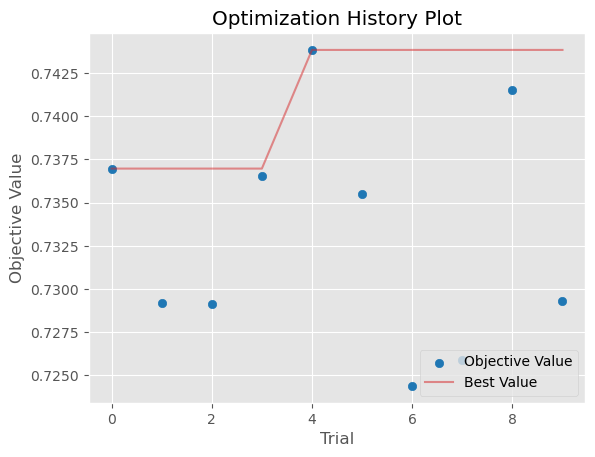

In [21]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
fig.legend(loc="lower right")

# Make final tuning

In [22]:
y_train = train_data["outcome"]
X_train = train_data.drop(columns=["outcome"])

d_full_train = xgboost.dask.DaskQuantileDMatrix(None, X_train, y_train)

In [23]:
final_model = xgboost.dask.train(
    None,
    {'objective':'multi:softmax',
     'num_class':3,
     "eval_metric": "mlogloss",
     "tree_method": "gpu_hist",
     'predictor':'gpu_predictor',
     **study.best_params},
    d_full_train,
    num_boost_round=XGB_grid_n_iter_search
)

[13:18:09] task [xgboost.dask-0]:tcp://127.0.0.1:36879 got new rank 0


# Collect final results

In [24]:
y_test = test_data["outcome"]
X_test = test_data.drop(columns=["outcome"])

d_test = xgboost.dask.DaskQuantileDMatrix(None, X_test, y_test)

In [25]:
predictions = xgboost.dask.predict(None, final_model, X_test)
score = accuracy_score(y_test.astype("float32"), predictions, convert_dtype=True)
score

0.735973596572876

In [26]:
dump(final_model['booster'], os.path.join(RESOURCES_DIR, 'model_xgboost_dask_cuml_v0.1.joblib'))

['/home/jgsolar/Documentos/SHARED/Projetos Pessoais/multiplatform_classifier/B_resources/d_DASK_CUDA_RAPIDS/model_xgboost_dask_cuml_v0.1.joblib']

In [27]:
client.shutdown()